<a href="https://colab.research.google.com/github/morgwork/Distantly-Reading-IPCC-Reports/blob/main/IPCC_Mitigation_Topic_Models_(4_24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tomotopy
!pip install little_mallet_wrapper

     |████████████████████████████████| 16.3 MB 5.0 MB/s 


In [2]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob # directories
from pathlib import Path

In [4]:
! unzip txt.zip

Archive:  txt.zip
  inflating: txt/IPCC1M.txt          
  inflating: txt/IPCC2M.txt          
  inflating: txt/IPCC3M.txt          
  inflating: txt/IPCC4M.txt          
  inflating: txt/IPCC5M.txt          
  inflating: txt/IPCC6M.txt          


In [7]:
directory = "/content/txt"

In [8]:
files= glob.glob(f"{directory}/*.txt")
files

['/content/txt/IPCC1M.txt',
 '/content/txt/IPCC5M.txt',
 '/content/txt/IPCC4M.txt',
 '/content/txt/IPCC2M.txt',
 '/content/txt/IPCC3M.txt',
 '/content/txt/IPCC6M.txt']

In [9]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)

len(training_data), len(original_texts), len(titles)

(6, 6, 6)

In [12]:
# Number of topics to return
num_topics = 30
# Numer of words to print out in each cluster
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())
    
print("Topic Model Training...\n\n")
# Iterate over the data 150 times
iterations = 150
for i in range(0, 150, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
# Print out top 10 words for each topic
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -9.213329522609323

Topic Model Results:


✨Topic 0✨

https //doi org/ climate energy cite quote distribute pages ipcc

✨Topic 1✨

climate use development range policies production estimates change including international

✨Topic 2✨

climate change greenhouse response could coastal percent emissions countries sea

✨Topic 3✨

mitigation energy scenarios ghg kyoto emissions policies costs annex carbon

✨Topic 4✨

sector new also iea climate emissions pathways policy adaptation model

✨Topic 5✨

economic change climate countries greenhouse social global policy costs country

✨Topic 6✨

security mitigation governance lock support example help solar systems indirect

✨Topic 7✨

range capacity progress summary particularly enabling providing within year bonds

✨Topic 8✨

emissions carbon technology international environment united energy also world terms

✨Topic 9✨

change cost industry technology eds electricity recent institute reducti

In [13]:
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [14]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

In [15]:
get_top_docs(titles, topic_distributions, topic_index=5, n=6)


### ✨Topic 5✨

economic change climate countries greenhouse social global policy costs country

---

✨  
**Topic Probability**: 0.2045549750328064  
**Document**: IPCC2M



✨  
**Topic Probability**: 0.1556883007287979  
**Document**: IPCC3M



✨  
**Topic Probability**: 0.10341224074363708  
**Document**: IPCC1M



✨  
**Topic Probability**: 0.06843042373657227  
**Document**: IPCC4M



✨  
**Topic Probability**: 0.055585335940122604  
**Document**: IPCC5M



✨  
**Topic Probability**: 0.021457118913531303  
**Document**: IPCC6M



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

In [17]:
target_labels = []

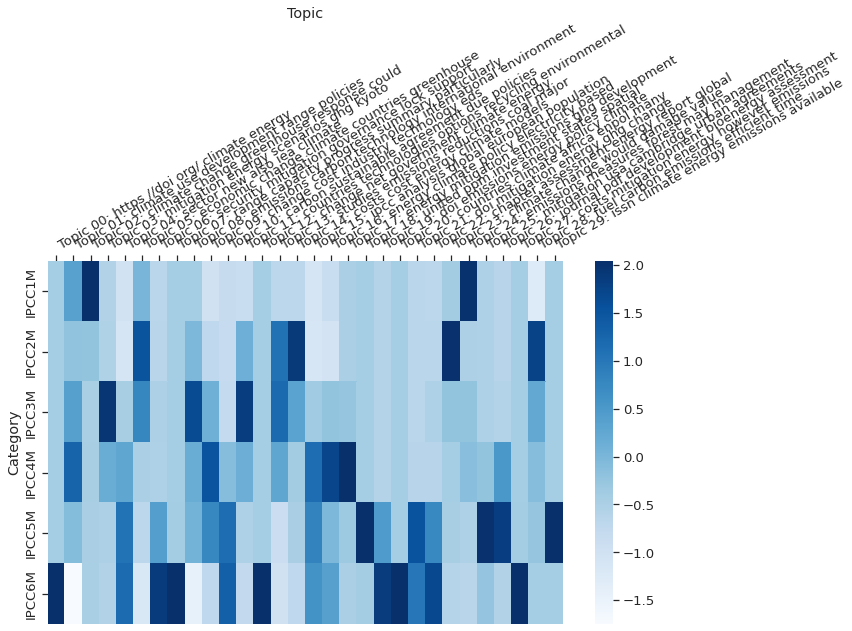

In [18]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(12,9))

In [ ]:
# For all possible color maps, see https://matplotlib.org/stable/tutorials/colors/colormaps.html#miscellaneous

In [19]:
import pandas as pd

topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)
column_names = [f"Topic {number} {' '.join(topic[:4])}" for number, topic in enumerate(topic_individual_words)]
df[column_names] = pd.DataFrame(df['topic_distribution'].tolist(), index = df.index)
df = df.drop('topic_distribution', axis='columns')

In [20]:
df.to_csv('Topic-Distributions.csv', encoding='utf-8', index=False)

In [21]:
df=pd.read_csv("/content/Topic-Distributions.csv", index_col=0)
df

,Topic 0 https //doi org/ climate,Topic 1 climate use development range,Topic 2 climate change greenhouse response,Topic 3 mitigation energy scenarios ghg,Topic 4 sector new also iea,Topic 5 economic change climate countries,Topic 6 security mitigation governance lock,Topic 7 range capacity progress summary,Topic 8 emissions carbon technology international,Topic 9 change cost industry technology,...,Topic 20 countries climate africa enpol,Topic 21 doi mitigation energy ghg,Topic 22 chapter assessment energy report,Topic 23 climate change would damage,Topic 24 emissions measures forest may,Topic 25 mitigation usa cambridge urban,Topic 26 journal pdf development bioenergy,Topic 27 costs mitigation energy however,Topic 28 fuel carbon emissions efficient,Topic 29 issn climate energy emissions
document,,,,,,,,,,,,,,,,,,,,,
IPCC1M,5.758546e-07,0.077275,0.320992,0.000003,0.003562,0.103412,0.000003,9.674303e-07,0.054200,0.011636,...,2.810641e-07,1.560672e-05,0.000003,0.017803,0.302936,1.301851e-06,1.989174e-06,1.001500e-06,0.024966,2.844232e-07
IPCC5M,6.886119e-08,0.064456,0.003135,0.004328,0.048094,0.055585,0.011794,1.283816e-04,0.060199,0.048521,...,3.360989e-08,7.274149e-02,0.033410,0.014766,0.055711,5.402738e-02,3.726150e-02,3.368179e-04,0.034193,1.265184e-01
IPCC4M,2.768962e-06,0.104284,0.006052,0.049250,0.031433,0.068430,0.001482,1.612117e-05,0.061577,0.064135,...,5.565440e-08,1.152677e-03,0.001408,0.016030,0.095044,6.616356e-03,1.733977e-02,1.347299e-05,0.035319,5.631954e-08
IPCC2M,2.203586e-07,0.060991,0.036000,0.001325,0.001984,0.204555,0.000206,3.702003e-07,0.059128,0.017372,...,1.075530e-07,5.972125e-06,0.000309,0.153797,0.057643,4.981710e-07,7.611844e-07,3.832376e-07,0.052610,1.088384e-07
IPCC3M,1.390048e-07,0.078415,0.004675,0.171287,0.015735,0.155688,0.001577,2.335267e-07,0.080280,0.034753,...,6.784568e-08,5.307788e-07,0.003483,0.027493,0.085065,3.142521e-07,5.506864e-04,2.417507e-07,0.038702,6.865653e-08
IPCC6M,1.825951e-01,0.015345,0.004198,0.000100,0.050589,0.021457,0.027756,2.491010e-02,0.041002,0.017506,...,4.855643e-02,5.427200e-02,0.055222,0.005762,0.044374,6.381942e-03,9.255705e-04,4.780411e-02,0.032660,2.368004e-08


**Derived from Week 14 topic modeling codebook.**